In [1]:
'https://www.kaggle.com/code/himanshu007121/covid-19-cough-classification/notebook'

'https://www.kaggle.com/code/himanshu007121/covid-19-cough-classification/notebook'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Library import

In [3]:
## basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## sk
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier

## tf
import tensorflow as tf
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics, utils
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,Activation, Flatten
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
import librosa
from keras import backend as K

## ect
import timeit
import cv2
import glob
import pickle
from tqdm.auto import tqdm
import os
import random
import warnings
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

## Data Load

In [5]:
raw_path = '/content/drive/MyDrive/Dacon/음향_데이터_covid-19_검출_AI_경진대회/data/raw'
extracted_path = '/content/drive/MyDrive/Dacon/음향_데이터_covid-19_검출_AI_경진대회/data/extracted'
submit_path = '/content/drive/MyDrive/Dacon/음향_데이터_covid-19_검출_AI_경진대회/data/submit'

In [6]:
audio_path_train = raw_path + '/train/'
audio_list_train = os.listdir(raw_path + '/train')
audio_list_train.sort()

In [7]:
path_train = raw_path + '/train/'
train_df = pd.read_csv( raw_path + '/train_data.csv')
test_df = pd.read_csv( raw_path + '/test_data.csv')

In [8]:
# train_df['file_name'] = audio_list_train
# train_df

## Hyperparameter Setting

In [9]:
CFG = {
    'SR': 16000,
    'N_MFCC': 50, # MFCC 벡터를 추출할 개수
    'SEED': 0xC0FFEE
}

## Fixed Random-Seed

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-Processing(MFCC)

In [11]:
def get_mfcc_feature(df, data_type, save_path):
    # Data Folder path
    root_folder = raw_path
    if os.path.exists(save_path):
        print(f'{save_path} is exist.')
        return
    features = []
    for uid in tqdm(df['id']):
        root_path = os.path.join(root_folder, data_type)
        path = os.path.join(root_path, str(uid).zfill(5)+'.wav')

        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
    
    # 기존의 자가진단 정보를 담은 데이터프레임에 추출된 오디오 Feature를 추가
    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1,CFG['N_MFCC']+1)])
    df = pd.concat([df, mfcc_df], axis=1)
    df.to_csv(save_path, index=False)
    print('Done.')

In [12]:
get_mfcc_feature(train_df, 'train', extracted_path + '/train_mfcc_data_50.csv')
get_mfcc_feature(test_df, 'test', extracted_path + '/test_mfcc_data_50.csv')

/content/drive/MyDrive/Dacon/음향_데이터_covid-19_검출_AI_경진대회/data/extracted/train_mfcc_data_50.csv is exist.
/content/drive/MyDrive/Dacon/음향_데이터_covid-19_검출_AI_경진대회/data/extracted/test_mfcc_data_50.csv is exist.


In [13]:
train_df = pd.read_csv(extracted_path + '/train_mfcc_data_50.csv')
test_df = pd.read_csv(extracted_path + '/test_mfcc_data_50.csv')

In [14]:
train_df

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_41,mfcc_42,mfcc_43,mfcc_44,mfcc_45,mfcc_46,mfcc_47,mfcc_48,mfcc_49,mfcc_50
0,1,24,female,0,1,0,-274.93472,29.345425,-19.152718,-7.836881,...,-0.298118,1.620007,-0.189207,-0.009375,-0.916391,0.379372,-0.502385,1.267371,-1.001481,0.148684
1,2,51,male,0,0,0,-311.55988,52.482780,-0.094471,-11.066645,...,-2.207031,0.185051,-1.317793,-1.697919,-2.844104,-1.035829,-1.598000,-0.478649,-2.872207,-1.188608
2,3,22,male,0,0,0,-438.28616,46.591045,-22.690268,-3.606580,...,1.323115,-0.264300,-0.146697,0.414209,2.356518,1.188707,0.624341,0.151204,-0.137996,0.115351
3,4,29,female,1,0,0,-368.42603,46.939438,-7.443070,-3.694368,...,0.436407,-2.126014,-0.657675,-0.739027,-0.354994,0.903007,-0.961282,0.264247,0.131446,-0.096870
4,5,23,male,0,0,0,-535.19300,7.167374,-7.420830,2.231418,...,-0.125211,0.514957,-0.323877,0.688014,-0.071853,0.073379,-0.164337,0.128290,-0.333106,0.150420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800,3801,53,male,0,0,0,-328.48108,68.198110,-40.380050,2.296546,...,-0.442653,2.956208,2.010417,6.544683,2.152195,3.919817,-0.586829,3.043753,0.752890,1.802627
3801,3802,25,male,0,0,0,-386.11325,74.041670,-12.082752,-0.463326,...,-2.380018,-3.134291,-2.468962,1.205908,-2.843024,2.852284,2.002623,0.932566,-0.801410,-2.214515
3802,3803,26,female,0,0,0,-347.16568,58.591610,12.996252,27.981964,...,-0.637624,-1.312530,-1.277582,-0.241971,-1.245945,-0.896407,-0.690950,-1.309467,-2.441561,-1.397786
3803,3804,27,female,0,0,0,-179.06174,70.699880,-14.584357,-10.161293,...,-0.551874,1.664962,-2.733651,0.169220,-2.922632,-0.072310,-0.439990,1.394020,-1.381344,-1.079986


In [15]:
test_df

,id,age,gender,respiratory_condition,fever_or_muscle_pain,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,mfcc_41,mfcc_42,mfcc_43,mfcc_44,mfcc_45,mfcc_46,mfcc_47,mfcc_48,mfcc_49,mfcc_50
0,3806,48,female,1,0,-619.98790,9.328649,0.821094,2.373343,-0.171163,...,-0.075370,0.048879,-0.051144,-0.090832,0.138763,0.094931,-0.006382,0.164335,0.129822,0.066439
1,3807,24,female,0,0,-493.60570,8.492651,-2.758262,-2.801817,-2.770231,...,-0.008671,0.110829,-0.063210,0.129454,-0.698817,0.023819,-0.737584,-0.052047,-0.277058,-0.072616
2,3808,29,male,0,0,-1058.84180,-2.350609,-7.395449,-0.689041,-5.432969,...,-2.167671,-1.389390,-0.268498,-1.206685,-1.050377,0.517709,1.461359,-0.486253,-2.803480,-2.660474
3,3809,39,female,0,0,-362.16165,27.119740,-9.231675,9.747519,-1.013352,...,-0.865810,0.654505,0.014184,0.780863,0.512879,2.036103,1.133719,0.984139,0.426467,-0.625020
4,3810,34,male,0,0,-387.59268,45.165874,-14.454832,-2.965205,-9.931789,...,1.614006,0.476397,-0.663059,0.971149,1.607477,0.385417,0.228075,0.665313,-0.246490,-0.469456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5727,9533,43,male,0,0,-363.15244,48.035835,6.562373,11.678885,-7.902833,...,-1.220690,0.016845,1.729388,-0.143680,-3.402059,-0.155770,-2.715824,-3.423486,-1.631058,1.757813
5728,9534,48,female,0,1,-650.22455,2.844074,2.063639,5.160136,-4.574105,...,0.114147,0.400605,0.145645,0.220069,0.076825,0.436533,-0.616114,0.616456,-0.471136,0.405937
5729,9535,44,female,0,0,-335.09128,54.100250,-15.533144,13.702870,-9.206227,...,1.431858,0.186831,1.537119,0.132506,1.113480,-0.249836,-0.674647,-0.474915,-0.323941,-0.451369
5730,9536,25,female,0,0,-534.98730,17.522040,-9.687601,5.585782,-8.310497,...,-0.492882,0.041084,-0.375458,0.117474,-0.149074,-0.232230,0.119648,-0.003592,0.145346,0.189100


In [16]:
# train_data, test_y, train_y, test_y = model_selection.train_test_split(train_x, train_y,
#                                                                                  test_size=0.3,
#                                                                                  random_state=0)

In [17]:
# wav 파일의 MFCC Feature와 상태정보를 합친 학습데이터를 불러옵니다.
train_df = pd.read_csv(extracted_path + '/train_mfcc_data_50.csv')

# 학습데이터를 모델의 input으로 들어갈 x와 label로 사용할 y로 분할
train_x = train_df.drop(columns=['id', 'covid19'])
train_y = train_df['covid19']

In [18]:
def onehot_encoding(ohe, x):
    # 학습데이터로 부터 fit된 one-hot encoder (ohe)를 받아 transform 시켜주는 함수
    encoded = ohe.transform(x['gender'].values.reshape(-1,1))
    encoded_df = pd.DataFrame(encoded, columns=ohe.categories_[0])
    x = pd.concat([x.drop(columns=['gender']), encoded_df], axis=1)
    return x

In [19]:
# 'gender' column의 경우 추가 전처리가 필요 -> OneHotEncoder 적용
ohe = OneHotEncoder(sparse=False)
ohe.fit(train_x['gender'].values.reshape(-1,1))
train_x = onehot_encoding(ohe, train_x)

In [20]:
train_x.shape

(3805, 56)

In [21]:
train_y.shape

(3805,)

In [22]:
# train_y one-hot vector
train_y = utils.to_categorical(train_y)

In [23]:
train_y.shape

(3805, 2)

## tensorflow.Keras.models

- Sequential

In [25]:
3805*38

144590

In [34]:
#Building the layers
model = models.Sequential()

# Dense-layer (with he-initialization)
model.add(layers.Dense(input_dim=56, units=256, activation=None, kernel_initializer=initializers.he_uniform()))
model.add(layers.BatchNormalization())
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dropout(rate=0.5)) # Dropout-layer

model.add(layers.Dense(units=2, activation='softmax'))

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               14592     
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               131584    
                                                                 
 activation_9 (Activation)   (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                      

In [36]:
####Compile the models
model.compile(optimizer=optimizers.Adam(),
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy,
                       f1score])

In [37]:
##### Training
history = model.fit(train_x, train_y, batch_size=50, epochs=500, validation_split=0.3) 

Epoch 1/500
54/54 [==============================] - 2s 9ms/step - loss: 0.6722 - categorical_accuracy: 0.8569 - f1score: 0.8589 - val_loss: 1.0787 - val_categorical_accuracy: 0.9168 - val_f1score: 0.9169
Epoch 2/500
54/54 [==============================] - 0s 4ms/step - loss: 0.4391 - categorical_accuracy: 0.8915 - f1score: 0.8909 - val_loss: 0.3350 - val_categorical_accuracy: 0.9037 - val_f1score: 0.9039
Epoch 3/500
54/54 [==============================] - 0s 4ms/step - loss: 0.3839 - categorical_accuracy: 0.8967 - f1score: 0.8971 - val_loss: 0.3299 - val_categorical_accuracy: 0.9124 - val_f1score: 0.9125
Epoch 4/500
54/54 [==============================] - 0s 4ms/step - loss: 0.3392 - categorical_accuracy: 0.9042 - f1score: 0.9024 - val_loss: 0.3509 - val_categorical_accuracy: 0.9159 - val_f1score: 0.9160
Epoch 5/500
54/54 [==============================] - 0s 4ms/step - loss: 0.3375 - categorical_accuracy: 0.9072 - f1score: 0.9075 - val_loss: 0.3163 - val_categorical_accuracy: 0.91

### Test the model

In [38]:
# 위의 학습데이터를 전처리한 과정과 동일하게 test data에도 적용
test_x = pd.read_csv(extracted_path + '/test_mfcc_data_50.csv')
test_x = test_x.drop(columns=['id'])
# Data Leakage에 유의하여 train data로만 학습된 ohe를 사용
test_x = onehot_encoding(ohe, test_x)

In [39]:
test_x.head()

,age,respiratory_condition,fever_or_muscle_pain,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,mfcc_44,mfcc_45,mfcc_46,mfcc_47,mfcc_48,mfcc_49,mfcc_50,female,male,other
0,48,1,0,-619.98790,9.328649,0.821094,2.373343,-0.171163,-1.189314,-3.113831,...,-0.090832,0.138763,0.094931,-0.006382,0.164335,0.129822,0.066439,1.0,0.0,0.0
1,24,0,0,-493.60570,8.492651,-2.758262,-2.801817,-2.770231,1.993531,-5.280821,...,0.129454,-0.698817,0.023819,-0.737584,-0.052047,-0.277058,-0.072616,1.0,0.0,0.0
2,29,0,0,-1058.84180,-2.350609,-7.395449,-0.689041,-5.432969,1.596380,-8.221005,...,-1.206685,-1.050377,0.517709,1.461359,-0.486253,-2.803480,-2.660474,0.0,1.0,0.0
3,39,0,0,-362.16165,27.119740,-9.231675,9.747519,-1.013352,-4.020472,-13.982765,...,0.780863,0.512879,2.036103,1.133719,0.984139,0.426467,-0.625020,1.0,0.0,0.0
4,34,0,0,-387.59268,45.165874,-14.454832,-2.965205,-9.931789,10.073367,-0.863068,...,0.971149,1.607477,0.385417,0.228075,0.665313,-0.246490,-0.469456,0.0,1.0,0.0


In [ ]:
# result = model.evaluate(test_x, test_y, batch_size=100)

# print('loss (cross-entropy) :', result[0])
# print('test accuracy :', result[1])
# print('test f1score :', result[2])
# print('test  val_accuracy :', result[3])

In [40]:
# Model 추론
preds = model.predict(test_x)

In [41]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'f1score', 'val_loss', 'val_categorical_accuracy', 'val_f1score'])

In [44]:
preds  = np.argmax(preds, axis =1)

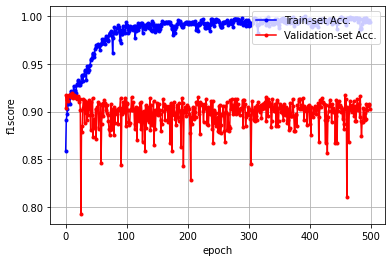

In [45]:
val_acc = history.history['val_f1score']
acc = history.history['f1score']

import numpy as np
import matplotlib.pyplot as plt

x_len = np.arange(len(acc))
plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('f1score')
plt.show()

In [50]:
submission = pd.read_csv(raw_path + '/sample_submission.csv', index_col=0)
submission['covid19'] = preds
submission.to_csv(submit_path + '/losses_categorical_crossentropy.csv', index='id')

In [48]:
submission

,covid19
id,
3806,0
3807,0
3808,0
3809,0
3810,0
...,...
9533,0
9534,0
9535,0
